### Importing libraries

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

### Import the data from a csv file.

In [27]:
data = pd.read_csv("train.csv")

## Data Exploration

In [28]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435


### Check count of unique id's in the dataset

In [29]:
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(data.id.nunique()))

There are 1458644 unique id's in Training dataset, which is equal to the number of records


### Convert timestamp to datetime format to fetch the other details as listed below

In [30]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

### Calculate and assign new columns to the dataframe such as weekday, month and pickup_hour which will help us to gain more insights from the data.

In [31]:
data['weekday'] = data.pickup_datetime.dt.day_name()
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.day_name()
data['pickup_hour'] = data.pickup_datetime.dt.hour

### Function to calculate distance between pickup and dropoff coordinates using Haversine formula.

In [32]:
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

### Calculate distance and assign new column to the dataframe.

In [33]:
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

### Calculate Speed in km/h for further insights

In [34]:
data['speed'] = (data.distance/(data.trip_duration/3600))

### Check the type of each variable

In [35]:
data.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


### Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

In [36]:
dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)
dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)
dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)
dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)
dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)
dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,...,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,...,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,...,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,...,0,1,0,0,0,0,0,0,0,0


## Univariate Analysis

### Passengers

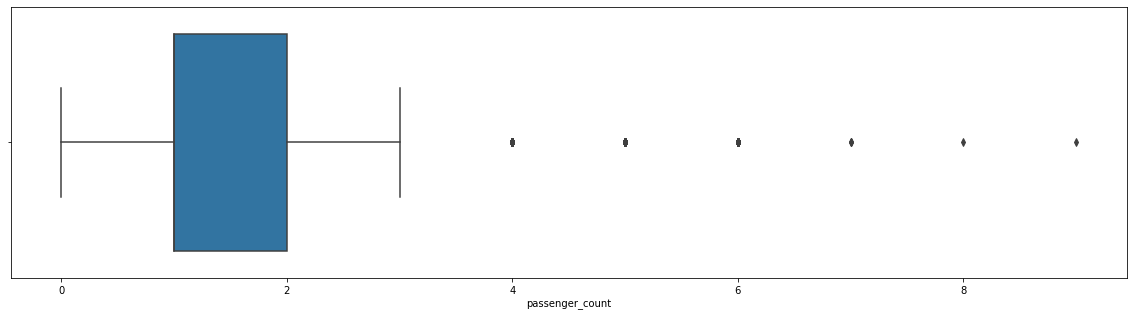

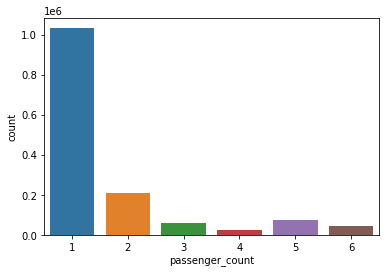

In [12]:
pd.options.display.float_format = '{:.2f}'.format
data.passenger_count.value_counts()
plt.figure(figsize = (20,5))
sns.boxplot(data.passenger_count)
plt.show()

data.passenger_count.describe()
data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)
data = data[data.passenger_count <= 6]
data.passenger_count.value_counts()
sns.countplot(data.passenger_count)
plt.show()

### Distance

count   1458639.00
mean          3.44
std           4.30
min           0.00
25%           1.23
50%           2.09
75%           3.88
max        1240.91
Name: distance, dtype: float64


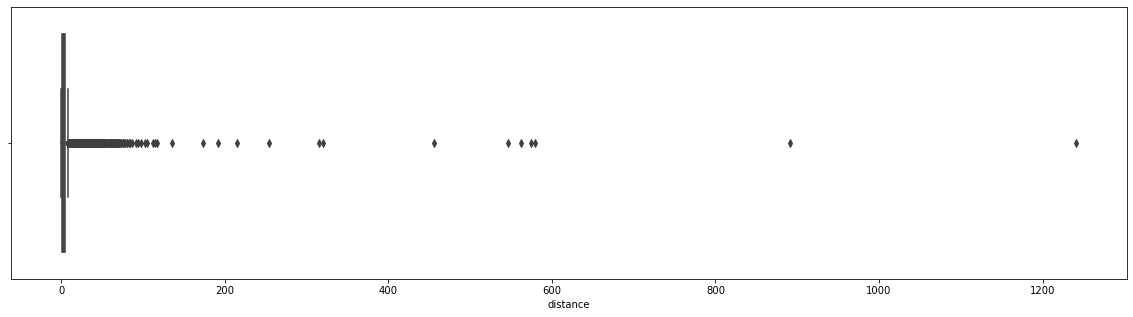

There are 5895 trip records with 0 km distance


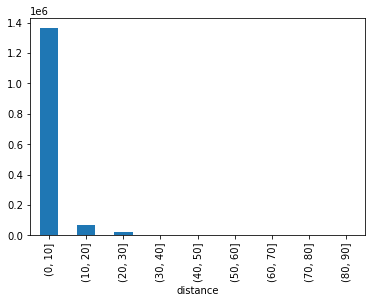

In [13]:
print(data.distance.describe())
plt.figure(figsize = (20,5))
sns.boxplot(data.distance)
plt.show()

print("There are {} trip records with 0 km distance".format(data.distance[data.distance == 0 ].count()))
data[data.distance == 0 ].head()
data.distance.groupby(pd.cut(data.distance, np.arange(0,100,10))).count().plot(kind='bar')
plt.show()

### Trip duration

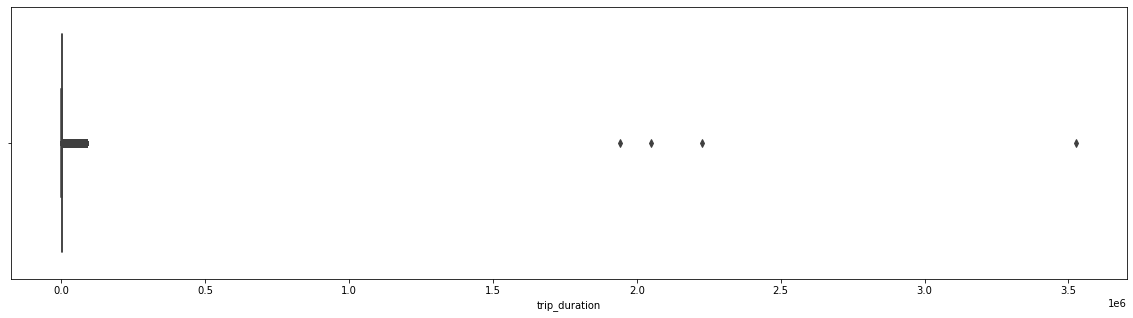

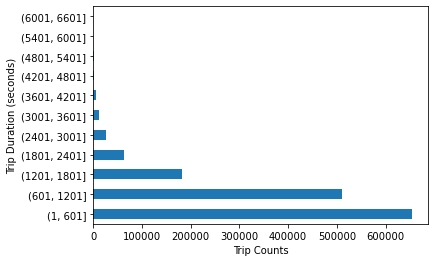

In [14]:
data.trip_duration.describe()
plt.figure(figsize = (20,5))
sns.boxplot(data.trip_duration)
plt.show()

data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,max(data.trip_duration),3600))).count()
data[data.trip_duration > 86400]
data = data[data.trip_duration <= 86400]
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

### Speed

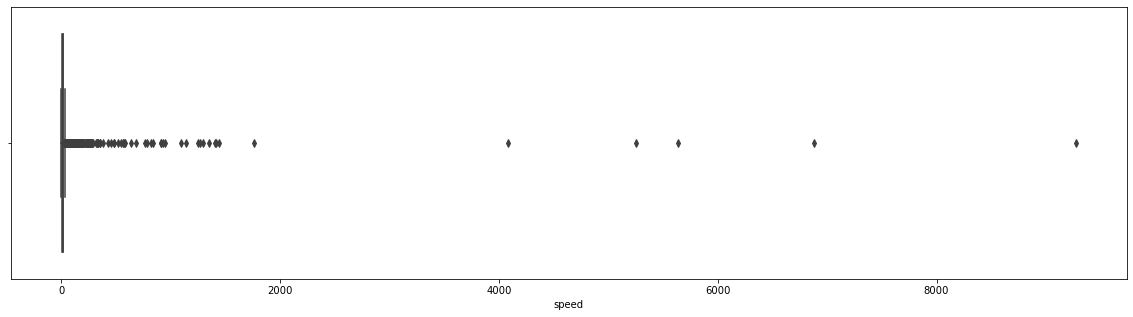

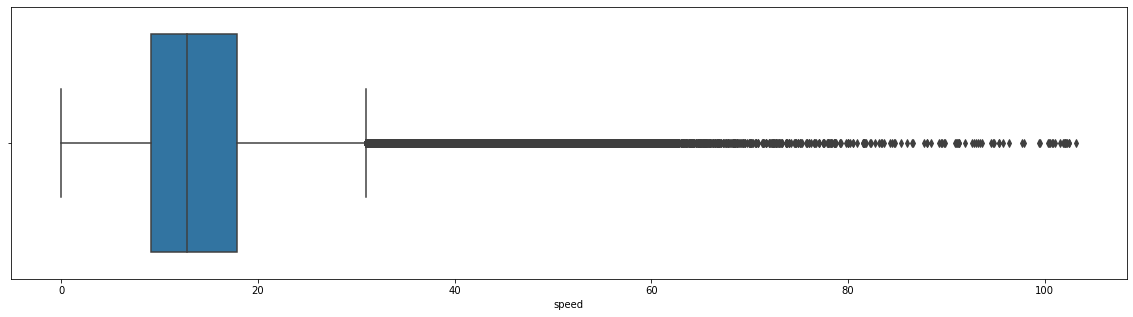

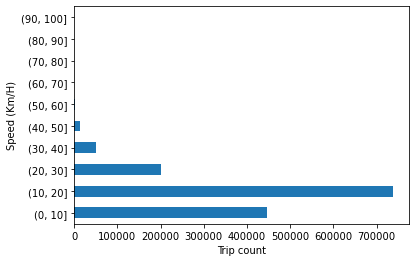

In [15]:
data.speed.describe()
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

data = data[data.speed <= 104]
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

### Total trips Per Hour

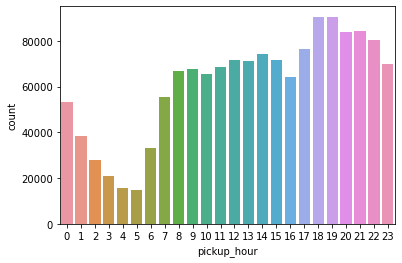

In [16]:
sns.countplot(data.pickup_hour)
plt.show()

### Total trips per weekday

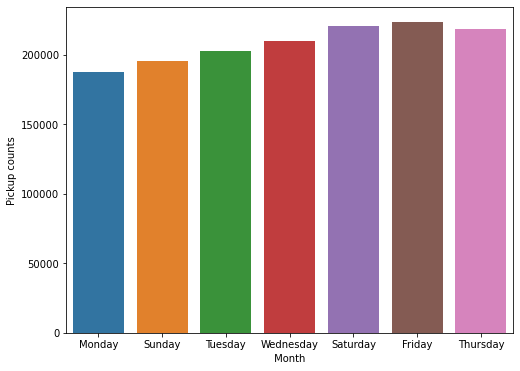

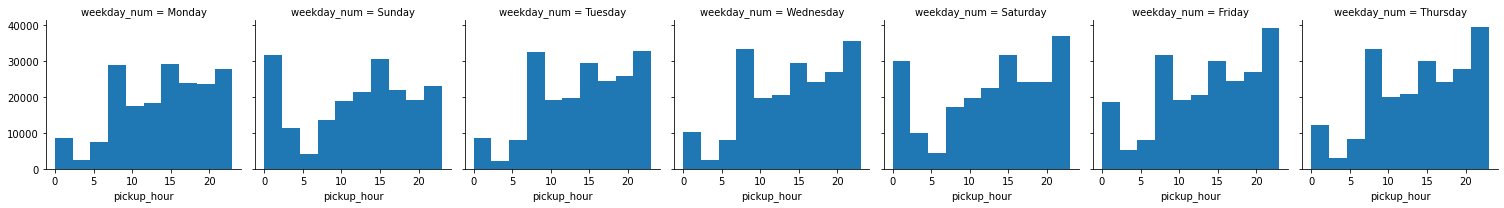

In [17]:
plt.figure(figsize = (8,6))
sns.countplot(data.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

n = sns.FacetGrid(data, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()

## Bivariate Analysis

### Trip Duration per hour

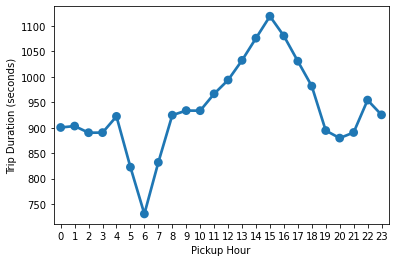

In [18]:
group1 = data.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

### Trip Duration per weekday

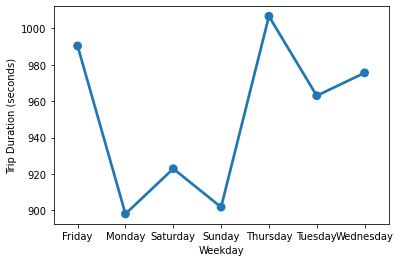

In [19]:
group2 = data.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

### Trip Duration per weekday

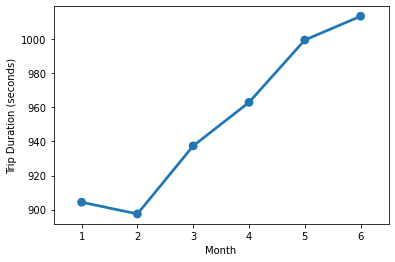

In [20]:
group3 = data.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

## Map Visualization

### Basemap

In [21]:
def map_marker(set):
   
    # Import package for map
    from mpl_toolkits.basemap import Basemap
    plt.figure(figsize = (20,20))
    
    # Set the limits of the map to the minimum and maximum coordinates
    lat_min = data["pickup_latitude"].min() - .2
    lat_max = data["pickup_latitude"].max() + .2
    lon_min = data["pickup_longitude"].min() - .2
    lon_max = data["pickup_longitude"].max() + .2
    
    # Set the center of the map
    cent_lat = (lat_min + lat_max) / 2
    cent_lon = (lon_min + lon_max) / 2
    
    #Create the Basemap object with required params.
    map = Basemap(llcrnrlon=lon_min,
        llcrnrlat=lat_min,
        urcrnrlon=lon_max,
        urcrnrlat=lat_max,
        resolution='l',
        projection='tmerc',
        lat_0 = cent_lat,
        lon_0 = cent_lon)
    
    #Style the map
    map.drawmapboundary()
    map.drawcoastlines()
    map.fillcontinents()
    map.drawcountries(linewidth=2)
    map.drawstates()
    
    #Fetch the long and lat in form of array
    long = np.array(data["pickup_longitude"])
    lat = np.array(data["pickup_latitude"])
    x, y = map(long, lat)
    map.plot(x, y,'ro', markersize=2, alpha=1)
    plt.show()

### Taxi pickup locations

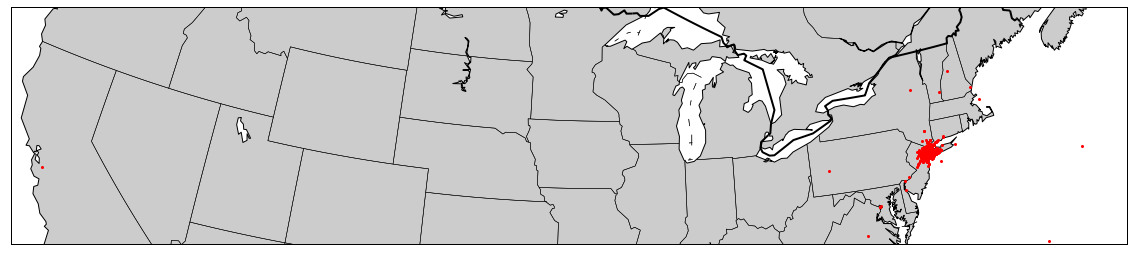

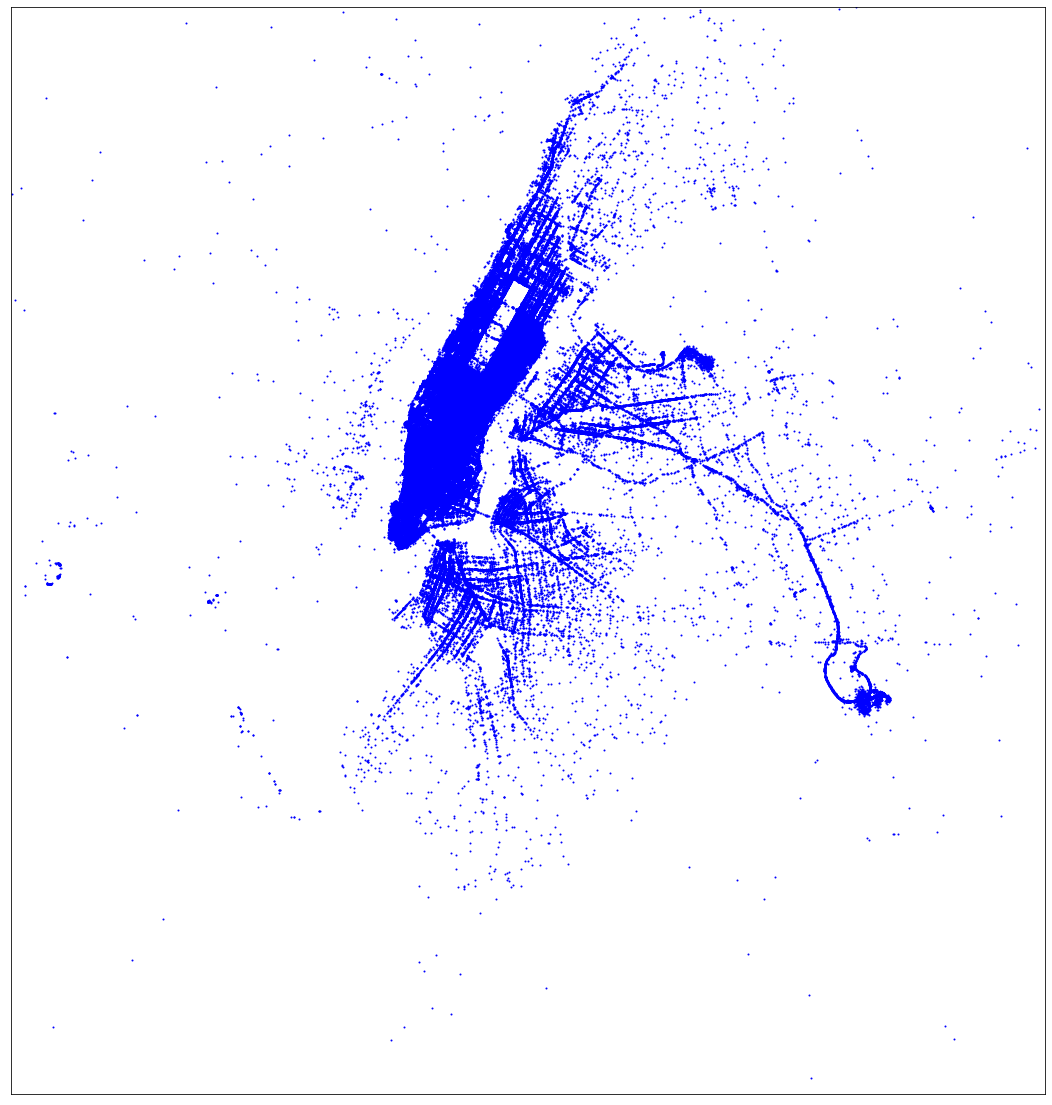

In [22]:
#CA state pickup
data[data.pickup_longitude == data.pickup_longitude.min()]
data[data.pickup_longitude == data.pickup_longitude.min()]
data = data[data.pickup_longitude != data.pickup_longitude.min()]
map_marker(data)

#NYC pickup locations
plt.figure(figsize=(20,20))
from mpl_toolkits.basemap import Basemap

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.5
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

#Create the Basemap object with required params.
map = Basemap(llcrnrlon=lon_min,
    llcrnrlat=lat_min,
    urcrnrlon=lon_max,
    urcrnrlat=lat_max,
    resolution='l',
    projection='tmerc',
    lat_0 = cent_lat,
    lon_0 = cent_lon)

#Style the map
# map.drawcounties()
#Fetch the long and lat in form of array
long = np.array(data["pickup_longitude"])
lat = np.array(data["pickup_latitude"])
x, y = map(long, lat)
map.plot(x, y,'bo', markersize=1, alpha=1)
plt.xticks()
plt.show()

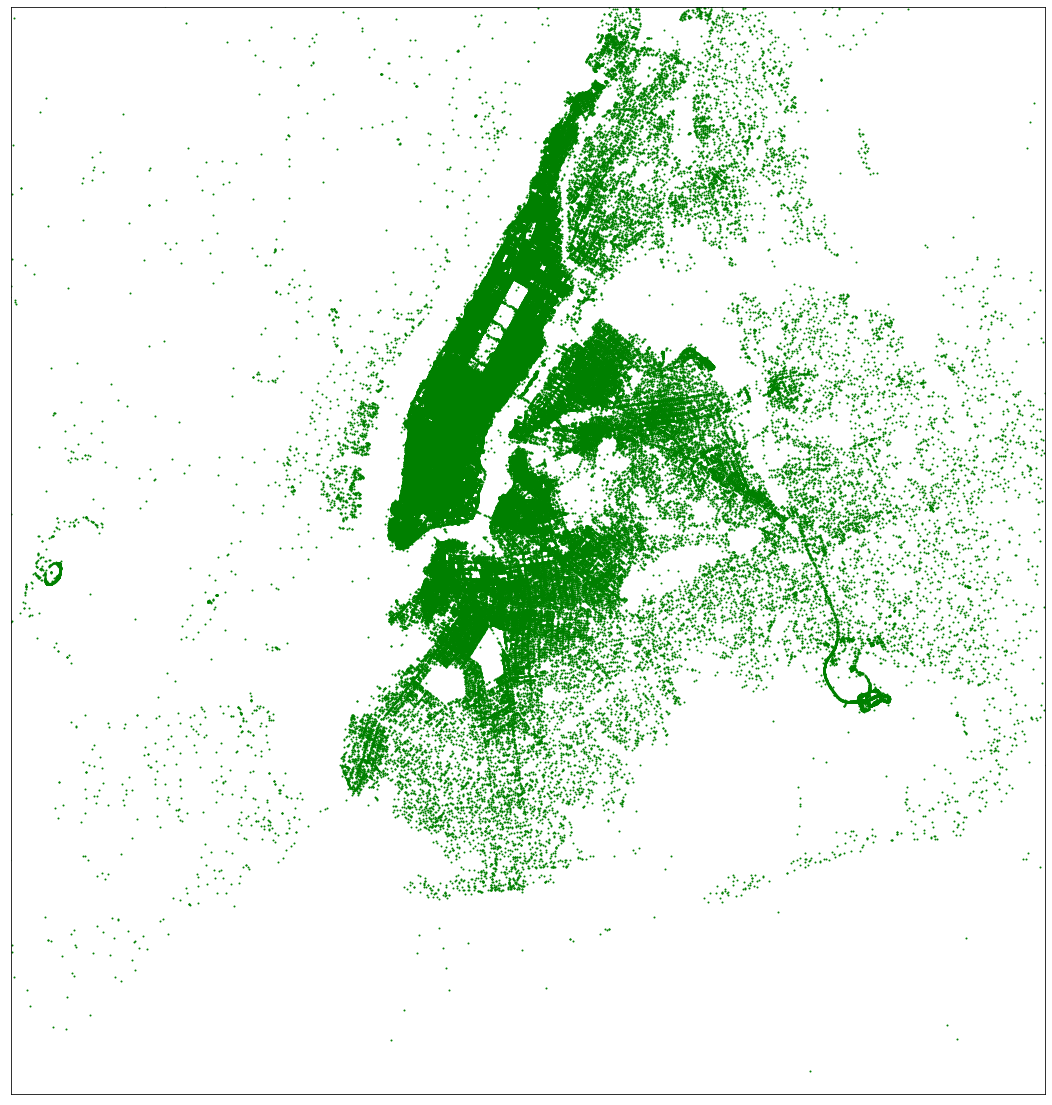

In [23]:
#NYC dropoff locations
plt.figure(figsize=(20,20))
# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.5
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7
# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2
#Create the Basemap object with required params.
map = Basemap(llcrnrlon=lon_min,
    llcrnrlat=lat_min,
    urcrnrlon=lon_max,
    urcrnrlat=lat_max,
    resolution='l',
    projection='tmerc',
    lat_0 = cent_lat,
    lon_0 = cent_lon)
#Style the map
# map.drawcounties()
#Fetch the long and lat in form of array
long = np.array(data["dropoff_longitude"])
lat = np.array(data["dropoff_latitude"])
x, y = map(long, lat)
map.plot(x, y,'go', markersize=1, alpha=1)
plt.xticks()
plt.show()

## Feature Engineering

### Feature Selection

In [25]:
#First chech the index of the features and label
list(zip( range(0,len(data.columns)),data.columns))
Y = data.iloc[:,10].values
X = data.iloc[:,range(15,61)].values
print("Let's append {} rows of 1's as the first column in the X array".format(X.shape[0]))
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)
X1.shape

#Select all the features in X array
X_opt = X1[:,range(0,46)]
regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()

Let's append 1458476 rows of 1's as the first column in the X array


IndexError: index 10 is out of bounds for axis 1 with size 10

In [ ]:
#Fetch p values for each feature
p_Vals = regressor_OLS.pvalues

In [ ]:
#define significance level for accepting the feature.
sig_Level = 0.05

In [ ]:
#Loop to iterate over features and remove the feature with p value less than the sig_level
while max(p_Vals) > sig_Level:
    print("Probability values of each feature \n")
    print(p_Vals)
    X_opt = np.delete(X_opt, np.argmax(p_Vals), axis = 1)
    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(p_Vals))))
    print(str(X_opt.shape[1]-1) + " dimensions remaining now... \n")
    regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()
    p_Vals = regressor_OLS.pvalues

In [ ]:
#Print final summary
print ("Final stat summary with optimal {} features".format(str(X_opt.shape[1]-1)))
regressor_OLS.summary()

In [ ]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

In [ ]:
#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

### Feature Extraction

In [ ]:
#Split Data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,Y, random_state=4, test_size=0.2)

In [ ]:
#Scale Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

In [ ]:
#PCA application
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))
pca_10 = PCA(n_components=40)
X_train_pca = pca_10.fit_transform(X_train_pca)
X_test_pca = pca_10.transform(X_test_pca)

## Models

### 1. Multiple Linear Regression

In [ ]:
#Linear regressor for the raw data
regressor = LinearRegression()
regressor.fit(X_train,y_train)

In [ ]:
#Linear regressor for the Feature selection group
regressor1 = LinearRegression()
regressor1.fit(X_train_fs,y_train_fs)

In [ ]:
#Linear regressor for the Feature extraction group
regressor2 = LinearRegression()
regressor2.fit(X_train_pca,y_train_pca)

### Model prediction

In [ ]:
#Predict from the test features of raw data
y_pred = regressor.predict(X_test)

In [ ]:
#Predict from the test features of Feature Selection group
y_pred = regressor1.predict(X_test_fs)

In [ ]:
#Predict from the test features of Feature Extraction group
y_pred_pca = regressor2.predict(X_test_pca)

### Model evaluation

In [ ]:
#Evaluate the regressor on the raw data
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score for the Multiple LR raw is : %.2f' % regressor.score(X_test, y_test))

In [ ]:
#Evaluate the regressor on the Feature selection group
print('RMSE score for the Multiple LR FS is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred))))
print('Variance score for the Multiple LR FS is : %.2f' % regressor1.score(X_test_fs, y_test_fs))

In [ ]:
#Evaluate the regressor on the Feature extraction group
print('RMSE score for the Multiple LR PCA is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca,y_pred_pca))))
print('Variance score for the Multiple LR PCA is : %.2f' % regressor2.score(X_test_pca, y_test_pca))

In [ ]:
#Find linear correlation of each feature with the target variable
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((X_train,y_train.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)
features = df1.iloc[:,:46].columns.tolist()
target = df1.iloc[:,46].name
correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]
X_train.shape

### 2. Random Forest

In [ ]:
#instantiate the object for the Random Forest Regressor with default params from raw data
regressor_rfraw = RandomForestRegressor(n_jobs=-1)

In [ ]:
#instantiate the object for the Random Forest Regressor with default params for Feature #Selection Group
regressor_rf = RandomForestRegressor(n_jobs=-1)

In [ ]:
#instantiate the object for the Random Forest Regressor with tuned hyper parameters for #Feature Selection Group
regressor_rf1 = RandomForestRegressor(n_estimators = 26,
    max_depth = 22,
    min_samples_split = 9,
    n_jobs=-1)

In [ ]:
#instantiate the object for the Random Forest Regressor for Feature Extraction Group
regressor_rf2 = RandomForestRegressor(n_jobs=-1)

In [ ]:
#Train the object with default params for raw data
regressor_rfraw.fit(X_train,y_train)

In [ ]:
#Train the object with default params for Feature Selection Group
regressor_rf.fit(X_train_fs,y_train_fs)

In [ ]:
#Train the object with tuned params for Feature Selection Group
regressor_rf1.fit(X_train_fs,y_train_fs)

In [ ]:
#Train the object with default params for Feature Extraction Group
regressor_rf2.fit(X_train_pca,y_train_pca)

### Model prediction

In [ ]:
#Predict the output with object of default params for Feature Selection Group
y_pred_rfraw = regressor_rfraw.predict(X_test)

In [ ]:
#Predict the output with object of default params for Feature Selection Group
y_pred_rf = regressor_rf.predict(X_test_fs)

In [ ]:
#Predict the output with object of hyper tuned params for Feature Selection Group
y_pred_rf1 = regressor_rf1.predict(X_test_fs)

In [ ]:
#Predict the output with object of PCA params for Feature Extraction Group
y_pred_rfpca = regressor_rf2.predict(X_test_pca)

### Model Evaluation

In [ ]:
#Evaluate the model with default params for raw data
print('RMSE score for the RF regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_rfraw))))
#print('RMSLE score for the RF regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_rfraw))))
print('Variance score for the RF regressor raw is : %.2f' % regressor_rfraw.score(X_test, y_test))

In [ ]:
#Evaluate the model with default params for Feature Selection Group
print('RMSE score for the RF regressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_rf))))
#print('RMSLE score for the RF regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_rf))))
print('Variance score for the RF regressor is : %.2f' % regressor_rf.score(X_test_fs, y_test_fs))

In [ ]:
# #Evaluate the model with tuned params for Feature Selection Group
print('RMSE score for the RF regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_rf1))))
#print('RMSLE score for the RF regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_rf1))))
print('Variance score for the RF regressor1 is : %.2f' % regressor_rf1.score(X_test_fs, y_test_fs))

In [ ]:
##Evaluate the model with PCA params for Feature Extraction Group
print('RMSE score for the RF regressor2 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca, y_pred_rfpca))))
print('Variance score for the RF regressor2 is : %.2f' % regressor_rf2.score(X_test_pca, y_test_pca))

### 3. XG Boost

In [ ]:
#instantiate the object for the XGBoost Regressor with default params for raw data
regressor_xgbraw = XGBRegressor(n_jobs=-1)

In [ ]:
#instantiate the object for the XGBoost Regressor with default params for Feature Selection #Group
regressor_xgb = XGBRegressor(n_jobs=-1)

In [ ]:
#instantiate the object for the XGBoost Regressor with tuned hyper parameters for Feature #Selection Group
regressor_xgb1 = XGBRegressor(n_estimators=300,
    learning_rate=0.08,
    gamma=0,
    subsample=0.75,
    colsample_bytree=1,
    max_depth=7,
    min_child_weight=4,
    silent=1,
    n_jobs=-1)

In [ ]:
#instantiate the object for the XGBoost Regressor for Feature Extraction Group
regressor_xgb2 = XGBRegressor(n_jobs=-1)

In [ ]:
#Train the object with default params for raw data
regressor_xgbraw.fit(X_train,y_train)

In [ ]:
#Train the object with default params for Feature Selection Group
regressor_xgb.fit(X_train_fs,y_train_fs)

In [ ]:
#Train the object with tuned params for Feature Selection Group
regressor_xgb1.fit(X_train_fs,y_train_fs)

In [ ]:
#Train the object with default params for Feature Extraction Group
regressor_xgb2.fit(X_train_pca,y_train_pca)

### Model Prediction

In [ ]:
#Predict the output with object of default params for raw data
y_pred_xgbraw = regressor_xgbraw.predict(X_test)

In [ ]:
#Predict the output with object of default params for Feature Selection Group
y_pred_xgb = regressor_xgb.predict(X_test_fs)

In [ ]:
#Predict the output with object of hyper tuned params for Feature Selection Group
y_pred_xgb1 = regressor_xgb1.predict(X_test_fs)

In [ ]:
#Predict the output with object of PCA params for Feature Extraction Group
y_pred_xgb_pca = regressor_xgb2.predict(X_test_pca)

### Model Evaluation

In [ ]:
#Evaluate the model with default params for raw data
print('RMSE score for the XGBoost regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_xgbraw))))
# print('RMSLE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_xgb))))
print('Variance score for the XGBoost regressor raw is : %.2f' % regressor_xgbraw.score(X_test, y_test))

In [ ]:
#Evaluate the model with default params for Feature Selection Group
print('RMSE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_xgb))))
# print('RMSLE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_xgb))))
print('Variance score for the XGBoost regressor is : %.2f' % regressor_xgb.score(X_test_fs, y_test_fs))

In [ ]:
#Evaluate the model with Tuned params for Feature Selection Group
print('RMSE score for the XGBoost regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_xgb1))))
# print('RMSLE score for the XGBoost regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_xgb1))))
print('Variance score for the XGBoost regressor1 is : %.2f' % regressor_xgb1.score(X_test_fs,y_test_fs))

In [ ]:
#Evaluate the model with PCA params for Feature Extraction Group
print('RMSE score for the XGBoost regressor2 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca, y_pred_xgb_pca))))
print('Variance score for the XGBoost regressor2 is : %.2f' % regressor_xgb2.score(X_test_pca, y_test_pca))

In [ ]:
#Comparing test results for the XGBoost and RF regressor
print("Total sum of difference between the actual and the predicted values for the RF regressor is : %d"%np.abs(np.sum(np.subtract(y_test,y_pred_rf))))
print("Total sum of difference between the actual and the predicted values for the tuned XGB regressor is : %d"%np.abs(np.sum(np.subtract(y_test,y_pred_xgb1))))

## 4. Deep Neural Network

In [ ]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import mean_absolute_error 
import tensorflow as tf

In [ ]:
NN = Sequential()

# The Input Layer :
NN.add(Dense(64, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN.add(Dense(32, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN.compile(loss = 'mean_absolute_error', optimizer='adam' ,metrics=['mean_absolute_error'])
NN.summary()

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

In [ ]:
wights_file = 'Weights-100--8.57472.hdf5' # choose the best checkpoint 
NN.load_weights(wights_file) # load it
NN.compile(loss='mean_absolute_error', optimizer= optimizer, metrics=['mean_absolute_error'])

In [ ]:
y_pred_NN = NN.predict(X_test)

In [ ]:
print('RMSE score for the Neural Network raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_NN))))
# print('RMSLE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_NN))))
# print('Variance score for the Neural Network raw is : %.2f' % NN.score(X_test, y_test))